In [1]:
import csv
import os
import sys

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from torchvision import datasets, models, transforms

from skimage.transform import resize
from utils import normalize

In [2]:
sys.path.append("/users/ruthfong")
from pytorch_workflow import pytorch_utils as utils

In [3]:
def get_gt_bbox(file_path, gt_annotation_file="/scratch/shared/slow/ruthfong/ILSVRC2012/val.csv"):
    image_name = file_path.split('/')[-1]
    filename = file_path.split('/')[-1].strip('.JPEG')
    synset = file_path.split('/')[-2]
    bboxes = None
    with open(gt_annotation_file) as csv_file:
        csv_reader = csv.DictReader(csv_file, delimiter=',')
        for row in csv_reader:
            if row["fname"] == filename:
                xmin = int(row["xmin"])
                ymin = int(row["ymin"])
                xmax = int(row["xmax"])
                ymax = int(row["ymax"])
                bbgt = (xmin, ymin, xmax, ymax)
                resize_shape = (int(row["height"]), int(row["width"]))
                return bbgt, resize_shape

In [4]:
def binarize_heatmap(mask, resize_shape, alpha, method):
    if (not np.max(mask) <= 1) or (not np.min(mask) >= 0):
        mask = normalize(mask)
    assert(np.max(mask) <= 1)
    assert(np.min(mask) >= 0)

    # Resize mask to original image dimensions.
    resized_mask = resize(mask, resize_shape)
    assert(np.max(resized_mask) <= 1)
    assert(np.min(resized_mask) >= 0)

    # Threshold mask and get smallest bounding box coordinates.
    heatmap = resized_mask
    if method == 'mean':
        threshold = alpha*heatmap.mean()
        heatmap = heatmap >= threshold
    elif method == 'min_max_diff':
        threshold = alpha*(heatmap.max()-heatmap.min())
        heatmap_m = heatmap - heatmap.min()
        heatmap = heatmap_m >= threshold
        heatmap[heatmap_m < threshold] = 0
    elif method == 'energy':
        heatmap_f = heatmap.flatten()
        sorted_idx = np.argsort(heatmap_f)[::-1]
        tot_energy = heatmap.sum()
        heatmap_cum = np.cumsum(heatmap_f[sorted_idx])
        ind = np.where(heatmap_cum >= alpha*tot_energy)[0][0]
        heatmap_f = np.ones(heatmap_f.shape)
        heatmap_f[sorted_idx[ind:]] = 0
        heatmap = np.reshape(heatmap_f, heatmap.shape)
    return heatmap

In [5]:
bbox_dir = "/scratch/shared/slow/mandela/bbox_results"
attribution_method = "grad_cam"
threshold_method = "min_max_diff"
# indexes = [25, 100, 346, 75, 100]

if threshold_method == "mean":
    alphas = np.linspace(0, 9.5, 20)
else:
    alphas = np.linspace(0, 0.95, 20)

data_dir = f"/scratch/shared/slow/mandela/{attribution_method}"

In [6]:
file_paths = np.loadtxt("./data/val_imdb_0_1000.txt", dtype=str)[:, 0] # [indexes, 0]

In [7]:
best_res = torch.load(os.path.join(bbox_dir, f"{attribution_method}_{threshold_method}_bbox_dict.pth"))
best_alpha = best_res["best_alpha"]
print(f"Best Alpha {best_alpha: .2f}")

Best Alpha  0.30


In [8]:
bboxes = {}
for alpha in alphas:
    y = np.loadtxt(os.path.join(bbox_dir, f"bb_val_{attribution_method}_{threshold_method}_{alpha:.2f}.txt"),
                   dtype={'names': ('synset', 'x0', 'y0', 'x1', 'y1'),
                          'formats': ('S10', 'i4', 'i4', 'i4', 'i4')})
    bboxes[alpha] = y

In [31]:
class SaliencyBase(object):
    def __init__(self, model, layer, upsample=True):
        self.model = model
        self.layer = layer
        module = utils.get_pytorch_module(model, layer)
        assert module is not None
        self.module = module
        self.upsample = upsample
        
    def _check_tensor_validity(self, x, y):
        assert isinstance(x, torch.Tensor)
        assert isinstance(y, torch.Tensor)

        # TODO(ruthfong): Generalize so it works for segmentation labels as well.
        assert len(y.shape) == 1
        assert x.shape[0] == y.shape[0]

    # @abstractmethod
    def __call__(self, x, y):
        raise NotImplemented

In [ ]:
class GuidedBackprop(SaliencyBase):
    def __init__(self, model, layer, upsample=True):
        super(GuidedBackprop, self).__init__(model=model, layer=layer, upsample=upsample)
        self.hooks = []

        self.gradients = []
        # Prepare to add hooks to get activations and gradients.
        activations = []
        def hook_acts(module, input, output):
            activations.append(output)

        gradients = []
        def hook_grads(module, grad_input, grad_output):
            gradients.append(grad_input)

    # Add hooks.
    hooks = []
    hooks.append(module.register_forward_hook(hook_acts))
    hooks.append(module.register_backward_hook(hook_grads))

    def __call__(self, x, y):
        self._check_tensor_validity(x, y)
        pred_y = self.model(x)
        

    def __del__(self):
        print self.name, 'deleted'
        Counter.Count -= 1
        if Counter.Count == 0:
            print 'Last Counter object deleted'
        else:
            print Counter.Count, 'Counter objects remaining'


In [ ]:
def guided_backprop(model, x, y, layer, upsample=True):
    # Check validity of input and target output.
    assert isinstance(x, torch.Tensor)
    assert isinstance(y, torch.Tensor)
    # TODO(ruthfong): Generalize so it works for segmentation labels as well.
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]

    # Check validity of layer.
    module = utils.get_pytorch_module(model, layer)
    assert module is not None


In [26]:
def grad_cam(model, x, y, layer, upsample=True):
    # Check validity of input and target output.
    assert isinstance(x, torch.Tensor)
    assert isinstance(y, torch.Tensor)
    # TODO(ruthfong): Generalize so it works for segmentation labels as well.
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]

    # Check validity of layer.
    module = utils.get_pytorch_module(model, layer)
    assert module is not None

    # Prepare to add hooks to get activations and gradients.
    activations = []
    def hook_acts(module, input, output):
        activations.append(output)

    gradients = []
    def hook_grads(module, grad_input, grad_output):
        gradients.append(grad_input)

    # Add hooks.
    hooks = []
    hooks.append(module.register_forward_hook(hook_acts))
    hooks.append(module.register_backward_hook(hook_grads))

    pred_y = model(x)

    # Get activations.
    assert len(activations) == 1
    acts = activations[0]

    # Backpropagate signal based on gt label.
    weights = torch.zeros_like(pred_y)
    weights.scatter_(1, y[:, None], 1)
    pred_y.backward(weights)

    # Get gradients.
    assert len(gradients) == 1
    assert len(gradients[0]) == 1
    grad = gradients[0][0]

    # Apply GAP to gradients to get a weight vector.
    grad_weights = torch.mean(grad, (2, 3), keepdim=True)

    # Weight activations by gradient weight vector.
    grad_cam = torch.sum(acts * grad_weights, 1, keepdim=True)

    # Pass visualization through ReLU.
    grad_cam = torch.clamp(grad_cam, min=0)

    # Remove hooks.
    for h in hooks:
        h.remove()

    if upsample:
        grad_cam = torch.nn.functional.interpolate(grad_cam, size=x.shape[2:], mode='bilinear')

    return grad_cam

In [12]:
device = torch.device('cuda:1')
model = models.vgg16(pretrained=True).cuda(device=device)

In [37]:
i = 25
file_path = file_paths[i]

In [38]:
image = Image.open(file_path)
bb_gt, resize_shape = get_gt_bbox(file_path)

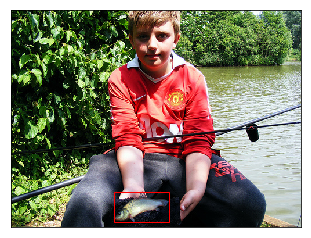

In [39]:
(xmin_gt, ymin_gt, xmax_gt, ymax_gt) = bb_gt
rect_gt = patches.Rectangle((xmin_gt, ymin_gt), xmax_gt-xmin_gt, 
    ymax_gt-ymin_gt, linewidth=1, edgecolor='r',facecolor='none')
f, ax = plt.subplots(1, 1)
# ax.imshow()
ax.imshow(image)
ax.add_patch(rect_gt)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [40]:
transform = utils.get_transform()
x = transform(image).unsqueeze(0).cuda(device=device)
y = torch.Tensor([0]).long().cuda(device=device)
layer = 'features.29' # last conv layer (pre-pooling; post-ReLU)

vis = grad_cam(model, x, y, layer, upsample=True)

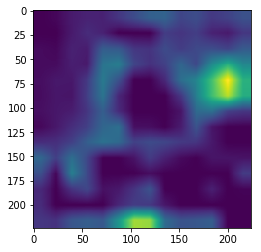

In [41]:
f, ax = plt.subplots(1, 1)
ax.imshow(vis.cpu().data.numpy().squeeze())
plt.show()

In [42]:
image_name = file_path.split('/')[-1]
filename = file_path.split('/')[-1].strip('.JPEG')
synset = file_path.split('/')[-2]

heatmap_path = os.path.join(data_dir, synset, image_name + ".pth")

heatmap_res = torch.load(heatmap_path)

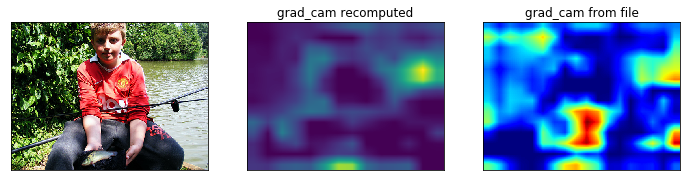

In [43]:
f, ax = plt.subplots(1, 3, figsize=(3*4, 4))
ax[0].imshow(image)
ax[1].imshow(resize(vis.cpu().data.numpy().squeeze(), resize_shape))
ax[1].set_title(f'{attribution_method} recomputed')
ax[2].imshow(heatmap_res['mask'].cpu().data.numpy().squeeze(), cmap='jet')
ax[2].set_title(f'{attribution_method} from file')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

[ True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]


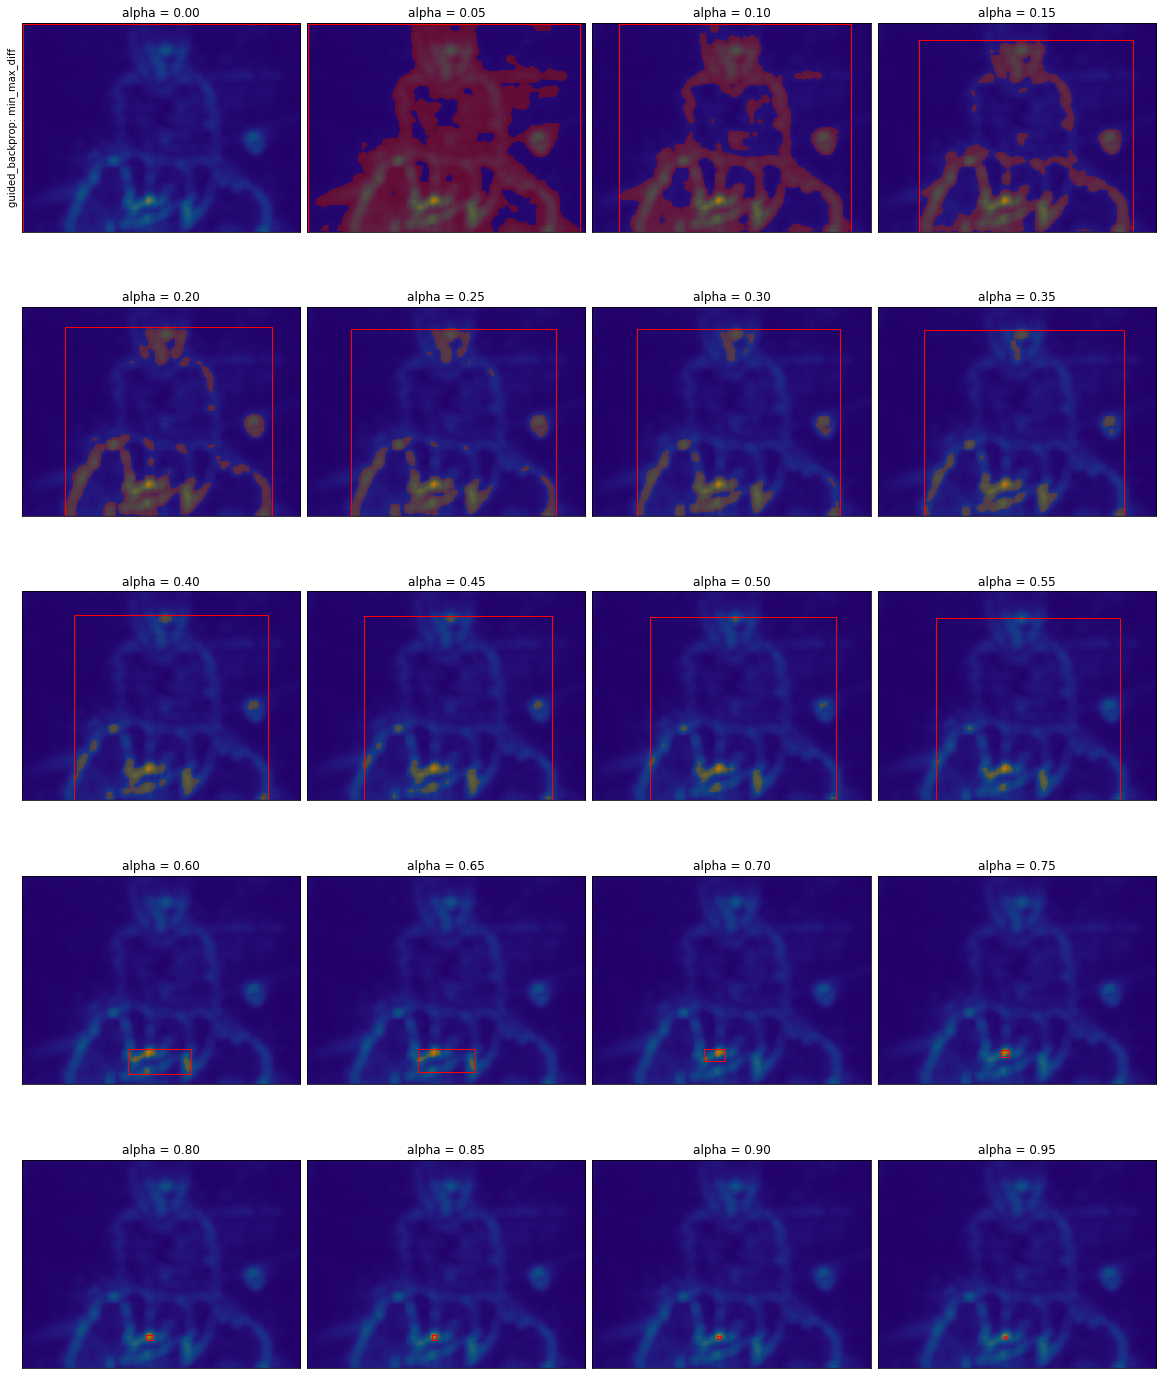

In [182]:
ncols = 4
nrows = 20 // ncols
f, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
for j in range(len(alphas)):
    alpha = alphas[j]
    (xmin, ymin, xmax, ymax) = list(bboxes[alpha][i])[1:]
    rect_alpha = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    mask = heatmap_res['mask'].cpu().data.numpy().squeeze()
    binary_mask = binarize_heatmap(mask, resize_shape, alpha, threshold_method)
    print(np.unique(binary_mask))
    ax[j//ncols][j%ncols].imshow(resize(mask, resize_shape))
    ax[j//ncols][j%ncols].imshow(binary_mask, alpha=0.5, cmap='jet')
    ax[j//ncols][j%ncols].add_patch(rect_alpha)
    ax[j//ncols][j%ncols].set_title(f"alpha = {alpha:.2f}")
    ax[j//ncols][j%ncols].set_xticks([])
    ax[j//ncols][j%ncols].set_yticks([])
ax[0][0].set_ylabel(f"{attribution_method}: {threshold_method}")
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.show()